# Enhancing our pipeline to have better prediction for "Failure Type"

As saw in previous steps, the best models for our binary prediction of "Failure Type" are:
- Logistic Regression,
- SVM,
- Neural Network, 
All tested on original dataset which will be resampled with RUS and SMOTE within respectiv pipeline.

Optimized parameters are found in others notebook via a GridSearch. So now, we will try to test different way to combine the prediction directly on the final prediction

After that, we will be able to combine this prediction with Failure Type prediction to obtain our final y_pred.

#### Importing librairies

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#### Models

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#### Loading datasets

In [3]:
#training
X_train = pd.read_csv('X_train.csv', sep=',')
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]

y_train = pd.read_csv('y_train.csv', sep=',')
y_train_failure_type = y_train['Failure Type']
y_train_failure_type.columns = ['Failure_Type']

#RUS and SMOTE for Failure Type 
X_train_rus_smote = pd.read_csv('X_train_resampled_failure_type.csv', sep=',')
X_train_rus_smote.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train_rus_smote.columns]
y_train_rus_smote = pd.read_csv('y_train_resampled_failure_type.csv', sep=',')
y_train_rus_smote = y_train_rus_smote['Failure Type']
y_train_rus_smote.columns = ['Failure Type']


#testing
X_test = pd.read_csv('X_test.csv', sep=',')
X_test.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_test.columns]

y_test = pd.read_csv('y_test.csv', sep=',')
y_test_failure_type = y_test['Failure Type']
y_test_failure_type.columns = ['Failure Type']


Models with optimized parameters

In [6]:
logreg = LogisticRegression(
    random_state=42,
    max_iter=500, 
    C=10.0,
    class_weight = 'balanced',
    penalty = 'l1',
    solver = 'saga',
    multi_class="ovr")

svm_base = SVC(
    random_state=42, 
    probability=True, 
    max_iter=1000,
    kernel='linear', 
    class_weight= None,
    C=10.0, 
    gamma='scale')
                
nn = MLPClassifier(
    hidden_layer_sizes=(64,32),
    random_state=42, 
    max_iter=300, 
    early_stopping=True,
    activation='tanh',
    alpha = 0.0001,
    batch_size = 32,
    learning_rate_init=0.01)


## With Voting Classifier applied on Bagging models

by fitting directly with the RUS + SMOTE dataset

In [7]:
bag_logreg = BaggingClassifier(
    estimator=logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=svm_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_logreg', bag_logreg),
        ('bag_svm', bag_svm),
        ('bag_nn', bag_nn)
    ],
    voting='soft',     # "soft" uses probabilities which is more appropriate due to multi classes here
    n_jobs=-1
)

voting_clf.fit(X_train_rus_smote, y_train_rus_smote)

y_pred_failure_type = voting_clf.predict(X_test)

Evaluation of Voting Classifier

In [8]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.8389 
Accuracy: 0.7414 
Balanced Accuracy: 0.8389 
F1-score: 0.3806


#### Visualization

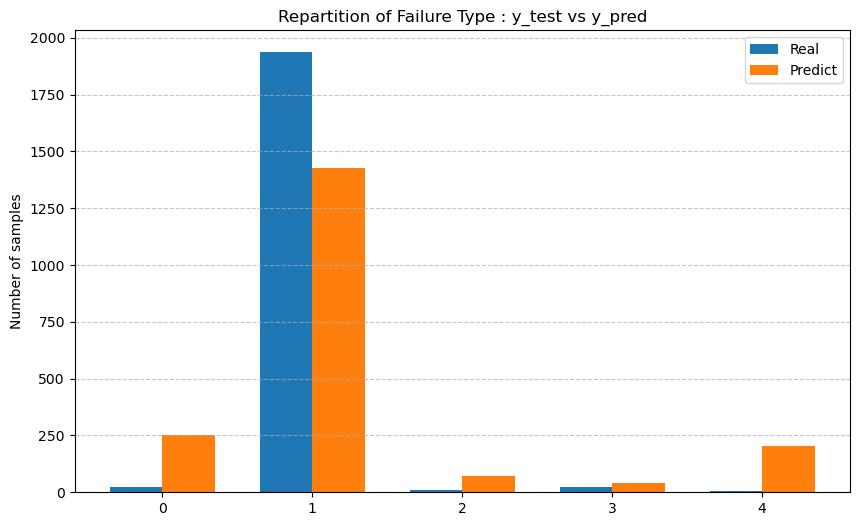

In [9]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [10]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

Real:
 Failure Type
1    1936
0      23
3      23
2       8
4       5
Name: count, dtype: int64 
VS Predict:
 0
1    1427
0     251
4     204
2      71
3      42
Name: count, dtype: int64


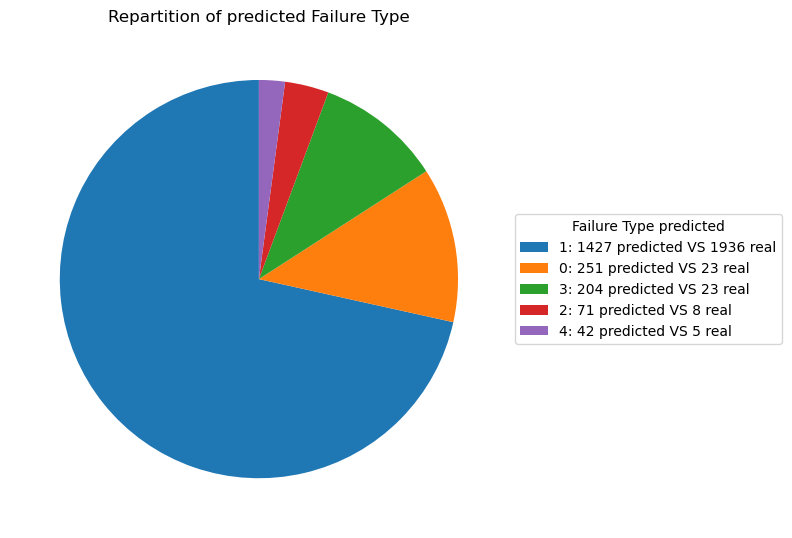

In [11]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type[0].value_counts()

print(f'Real:\n {failure_counts} \nVS Predict:\n {failure_counts_pred}')

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count 
    in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

The recall is pretty high, but the repartition has been very bad predicted. Accuracy is very low.


## With Voting Classifier applied on Bagging models (that are RUS and SMOTE within their pipeline)

In [12]:
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', logreg) #parametres a checker avec les filles gridsearch
])

pipe_svm_base = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', svm_base)
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', nn)
])


bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm_base,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[
        ('bag_logreg', bag_logreg),
        ('bag_svm', bag_svm),
        ('bag_nn', bag_nn)
    ],
    voting='soft',     # "soft" uses probabilities which is more appropriate due to multi classes here
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_failure_type)

y_pred_failure_type = voting_clf.predict(X_test)

Evaluation

In [13]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.9373 
Accuracy: 0.7789 
Balanced Accuracy: 0.9373 
F1-score: 0.3902


#### Visualization

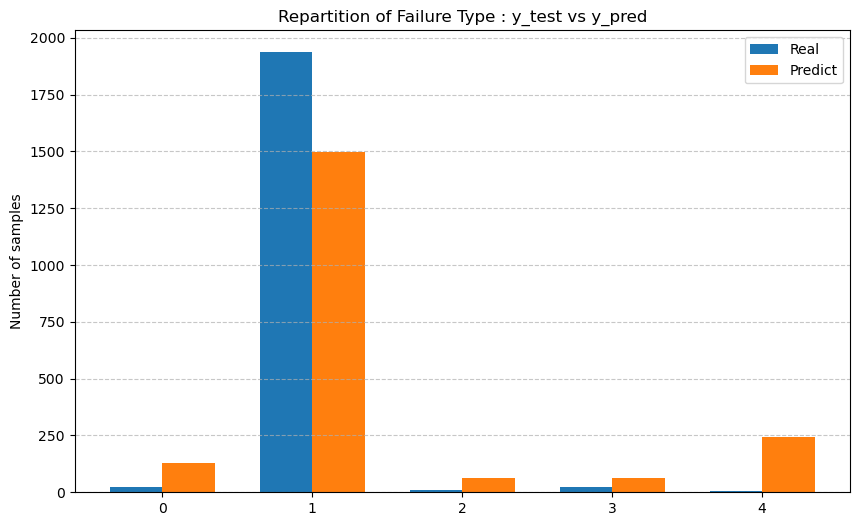

In [14]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [15]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

Real:
 Failure Type
1    1936
0      23
3      23
2       8
4       5
Name: count, dtype: int64 
VS Predict:
 0
1    1497
4     243
0     128
2      65
3      62
Name: count, dtype: int64


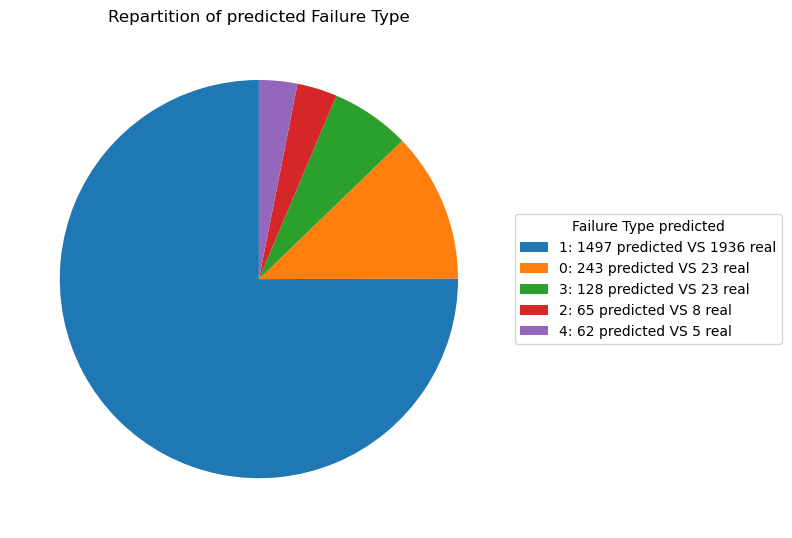

In [16]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type[0].value_counts()

print(f'Real:\n {failure_counts} \nVS Predict:\n {failure_counts_pred}')

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count 
    in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

Too many failure are wrong predicted, and too many failure are predicted as a failure when there must be no failure.

## With Stacking with RUS and SMOTE within the pipeline, with logreg as meta model

In [17]:
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', logreg) #parametres a checker avec les filles gridsearch
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', svm_base)
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', nn)
])


estimators = [
    ('lr', pipe_logreg),
    ('svm', pipe_svm),
    ('nn', pipe_nn)
]

meta = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000, 
    random_state=42)

#stacking classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)


stack.fit(X_train, y_train_failure_type)
probas = stack.predict_proba(X_test)

y_pred_failure_type = stack.predict(X_test)

Evaluation 

In [18]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.9044 
Accuracy: 0.7714 
Balanced Accuracy: 0.9044 
F1-score: 0.4189


In [19]:
print('\nRecall by class:')
for i, r in enumerate(recall_score(y_test_failure_type, y_pred_failure_type, average=None)):
    print(f'  Classe {i} : recall = {r:.4f}')
print(f"Recall_macro (test) = {recall_score(y_test_failure_type, y_pred_failure_type, average='macro'):.4f}")


Recall by class:
  Classe 0 : recall = 0.9565
  Classe 1 : recall = 0.7655
  Classe 2 : recall = 1.0000
  Classe 3 : recall = 1.0000
  Classe 4 : recall = 0.8000
Recall_macro (test) = 0.9044


#### Visualization

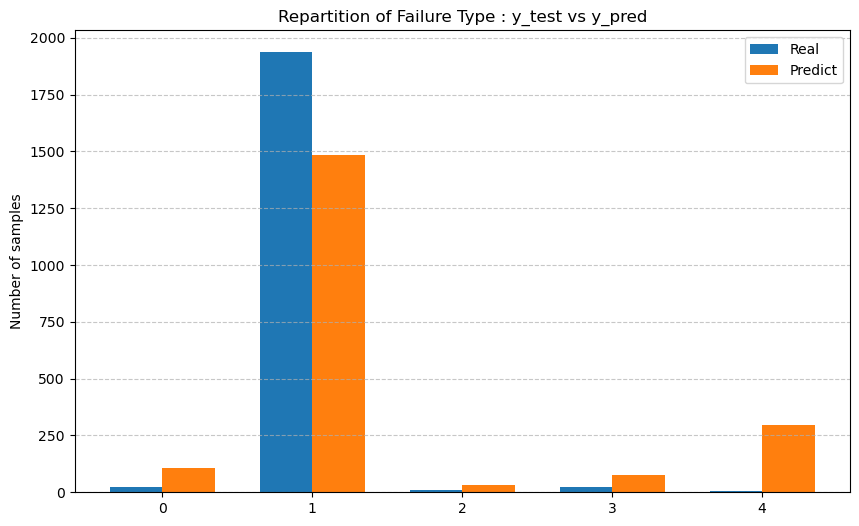

In [20]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

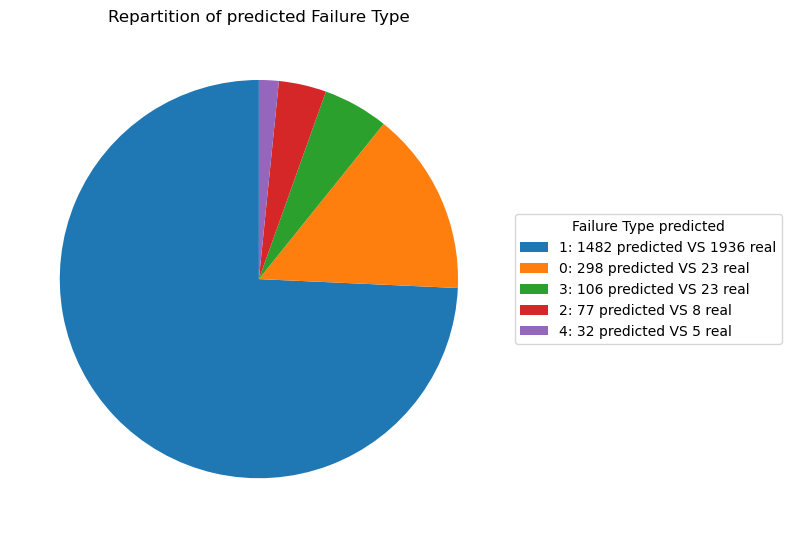

In [22]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type[0].value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

Recall is still high but we got too many predicted failure when there is not as much failure in the real dataset.

## Bagging models for Stacking with Logistic Regression as meta model, RUS and SMOTE within pipelin

Same as previous but bagging the models before Stacking

In [23]:
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', logreg) 
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', svm_base)
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', nn)
])

bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

logreg = LogisticRegression()

stacking_clf = StackingClassifier(estimators=[
    ('bag_logreg', bag_logreg),
    ('bag_svm', bag_svm),
    ('bag_nn', bag_nn)], final_estimator=logreg)
stacking_clf.fit(X_train, y_train_failure_type)

y_pred_failure_type = stacking_clf.predict(X_test)

Evaluation

In [24]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.5923 
Accuracy: 0.9820 
Balanced Accuracy: 0.5923 
F1-score: 0.6086


#### Visualization

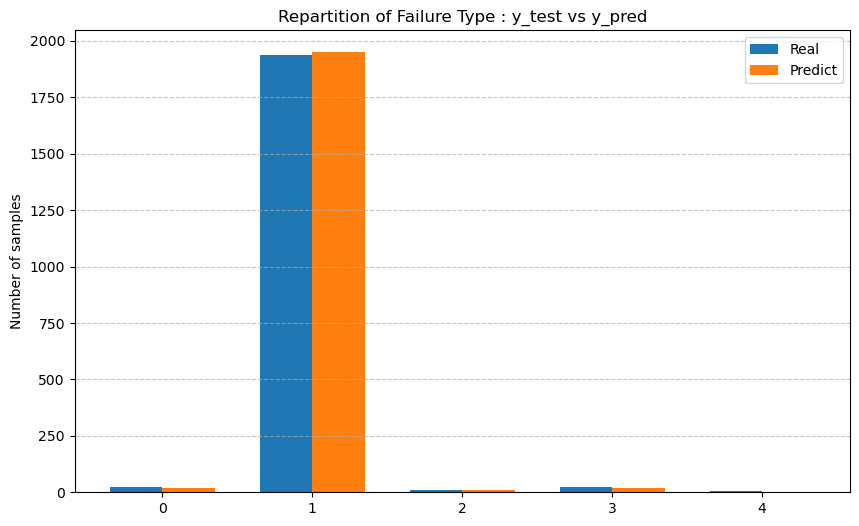

In [25]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
cm = confusion_matrix(y_test_failure_type, y_pred_failure_type)
cm

array([[  11,   11,    1,    0,    0],
       [   7, 1925,    2,    2,    0],
       [   0,    2,    6,    0,    0],
       [   0,    6,    0,   17,    0],
       [   0,    5,    0,    0,    0]], dtype=int64)

In [27]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

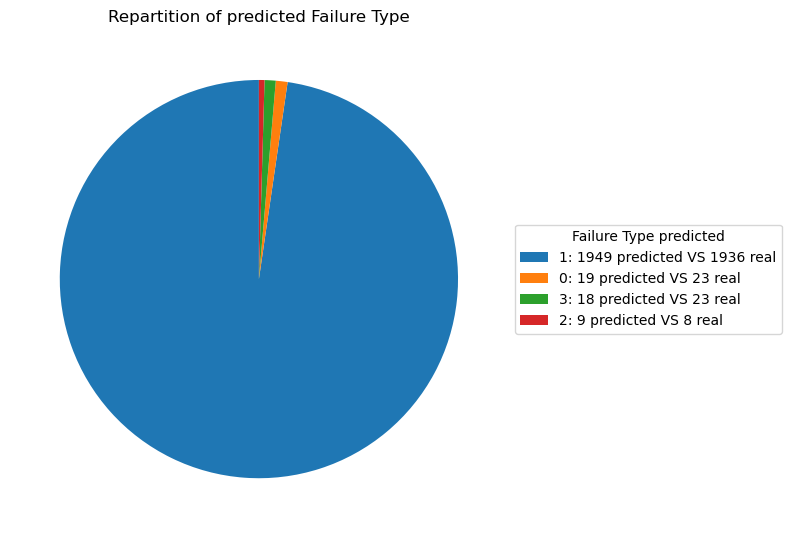

In [28]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type.value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

Even though recall score is not as high as expected, the repartition seems better, with less failures predicted. Given the confusion matrix, we can consider it as a good prediction (high accuracy and precision). 

So far, this is the **best prediction**

## Bagging models for Stacking with bagged Logistic Regression as meta model, and only Neural Network and SVC as base models, RUS and SMOTE within pipelin

In [29]:
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', logreg) #parametres a checker avec les filles gridsearch
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', svm_base)
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('clf', nn)
])

bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

stacking_clf = StackingClassifier(estimators=[
    ('bag_svm', bag_svm),
    ('bag_nn', bag_nn)], final_estimator=bag_logreg)
stacking_clf.fit(X_train, y_train_failure_type)

y_pred_failure_type = stacking_clf.predict(X_test)

Evaluation

In [30]:
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")

Recall: 0.9479 
Accuracy: 0.8306 
Balanced Accuracy: 0.9479 
F1-score: 0.4312


#### Visualization

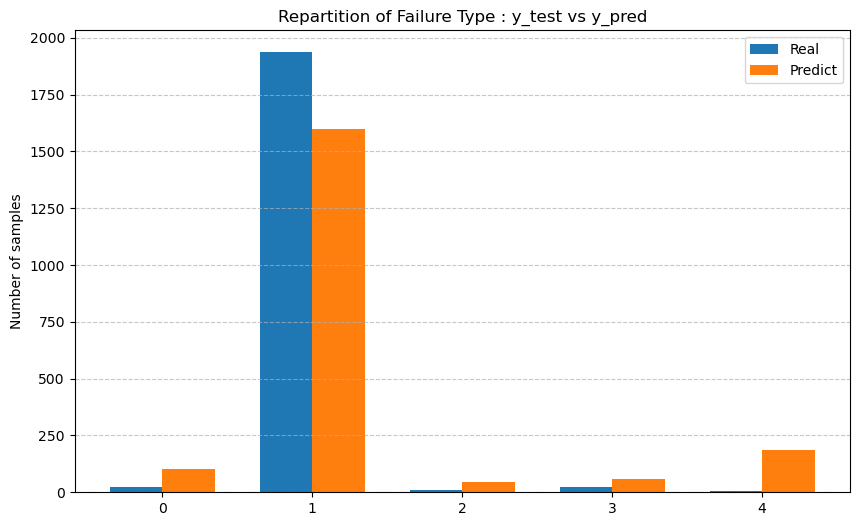

In [31]:
true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
y_pred_failure_type = pd.DataFrame.from_dict(y_pred_failure_type)

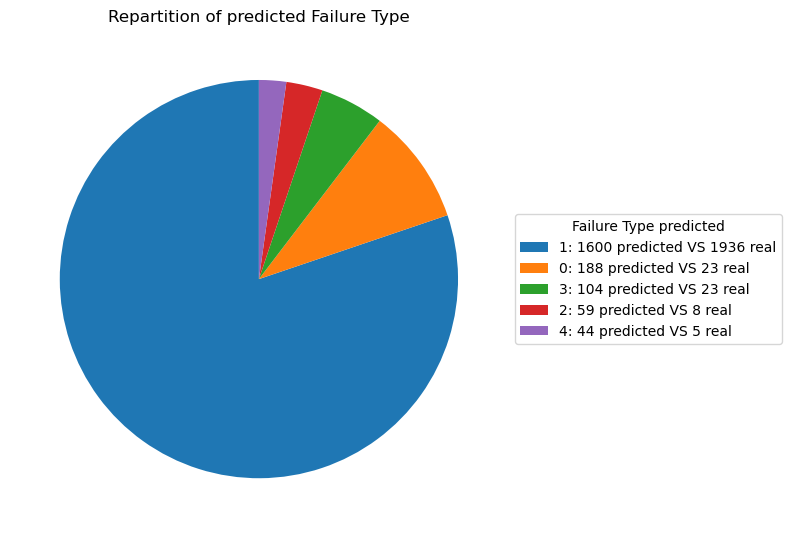

In [33]:
failure_counts = y_test_failure_type.value_counts()
failure_counts_pred = y_pred_failure_type.value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

When the bagging Logistic Regression is used a meta model and not as estimator, recall is way higher as previous case, but repartition is not as good: too many failure for each type.

## Discussion and conclusion

In the final prediction, this prediction will occurs only if a Target is detected. Given the result of Target, more or less rows are going to be predicted for Failure Type so we can try these two best predictions to know whether the recall is more important or the one that looks like the best repartition:

- Highest recall: 0.9479 for **Stacking bagged models with bagged Logistic Regression as meta model, and only Neural Network and SVC as base models, RUS and SMOTE within pipeline**
- Best repartition (not "too many" failure predicted unnecessarly): **Stacking bagged models with Logistic Regression as meta model, RUS and SMOTE within pipeline**